In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec

In [2]:
path_results = "../results/"

## General Preprocessing Functions

In [3]:
def preprocess_performance_dict(dict_path, model_names):
    with open(dict_path, "rb") as f:
        perf_dict = pickle.load(f)
    # Flatten the nested dictionary into a DataFrame
    rows = []
    for model_name, results in perf_dict.items():
        if model_name not in model_names:
            continue
        results = results['det_perfomance']
        for split, decoders in results.items():
            for decoder, metrics_list in decoders.items():
                for metrics in metrics_list:
                    row = {
                        'model_name': model_name,
                        'decoder': decoder,
                        'split': split
                    }
                    row.update(metrics)
                    rows.append(row)

    # Create the DataFrame
    df = pd.DataFrame(rows)

    # Pivot the DataFrame to create a hierarchical column format
    df_pivot = df.pivot_table(index=['model_name', 'decoder'], columns='split', aggfunc='first')

    # # Flatten multi-index columns
    df_pivot.columns = [f'{col[1]}_{col[0]}' for col in df_pivot.columns]
    df_pivot.reset_index(inplace=True)

    # # Ensure the desired order of columns
    split_order = ['val', 'test']  # Prioritize these splits
    remaining_splits = sorted(set(c.split('_')[0] for c in df_pivot.columns[2:]) - set(split_order))
    desired_order = split_order + remaining_splits

    # # Reorder columns
    ordered_columns = ['model_name', 'decoder'] + [
        col for split in desired_order
        for col in df_pivot.columns if col.startswith(split)
    ]

    val_columns = [col for col in ordered_columns if col.startswith('val')]
    test_columns = [col for col in ordered_columns if col.startswith('test')]


    df_names = df_pivot[['model_name', 'decoder']].rename(columns={"model_name": "Model Name", "decoder": "Decoder"})
    df_val = df_pivot[val_columns]
    # rename columns
    df_val = df_val.rename(columns={col: col.replace('val_test_', '') for col in df_val.columns}).rename(
        columns={
                "avg_pe": "PE",
                "sdr_2mm": "SDR 2mm",
                "sdr_2.5mm": "SDR 2.5mm",
                "sdr_3mm": "SDR 3mm",
                "sdr_4mm": "SDR 4mm",
                }
    ).drop(columns=["avg_loss"])
    df_test = df_pivot[test_columns]
    # rename columns
    df_test = df_test.rename(columns={col: col.replace('test_', '') for col in df_test.columns}).rename(
        columns={
                "avg_pe": "PE",
                "sdr_2mm": "SDR 2mm",
                "sdr_2.5mm": "SDR 2.5mm",
                "sdr_3mm": "SDR 3mm",
                "sdr_4mm": "SDR 4mm",
                }
    ).drop(columns=["avg_loss"])
    df_final = pd.concat({"Model Info": df_names, "Validation": df_val, "Test": df_test}, axis=1)

    # flatten multiindex Model Info
    df_final.columns = pd.MultiIndex.from_tuples([(("", col[1]) if col[0] == "Model Info" else col) for col in df_final.columns])

    df_final[("", "Model Name")] = df_final[("", "Model Name")].str.replace("_", " ").str.replace("landmark sampling", "LS").str.upper()

    df_final[("", "Decoder")] = df_final[("", "Decoder")].str.replace("_", " ")

    # all float columns to 4 decimal places
    float_cols = df_final.select_dtypes(include=['float64']).columns
    df_final[float_cols] = df_final[float_cols].round(4)

    # filter only the best model for each model based on PE Test
    df_final = df_final[df_final[("Test", "PE")].isin(df_final.groupby(("", "Model Name"))[[("Test", "PE")]].min().values.flatten())]

    # Reorder columns switch SDR 2mm and SDR 2.5mm
    df_final = df_final[[
        ("", "Model Name"), ("", "Decoder"),
        ("Validation", "PE"), ("Validation", "SDR 2mm"), ("Validation", "SDR 2.5mm"), ("Validation", "SDR 3mm"), ("Validation", "SDR 4mm"),
        ("Test", "PE"), ("Test", "SDR 2mm"), ("Test", "SDR 2.5mm"), ("Test", "SDR 3mm"), ("Test", "SDR 4mm"),
    ]]
    return df_final

def plot_error_area_scatter(df, save_path=None, dim=2, lim_axis=200):
    blue = np.array([75/255, 157/255, 220/255])
    red = np.array([238/255, 111/255, 117/255])
    # Error calculation

    # Create the figure and define the GridSpec layout
    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(2, 3*2, height_ratios=[1, 1], hspace=0.6, wspace=0.9)

    axs = [
        fig.add_subplot(gs[0, :2]),
        fig.add_subplot(gs[0, 2:4]),
        fig.add_subplot(gs[0, 4:6])
    ]
    axs.append(fig.add_subplot(gs[1, 0:2]))
    axs.append(fig.add_subplot(gs[1, 2:4]))
    axs.append(fig.add_subplot(gs[1, 4:6]))

    # Define titles for each subplot
    titles = [
        "Statistical Correction",
        "Maximum Nonconformity",
        "Ellipsoidal Conformal Prediction",
        "M-R2CCP",
        "M-R2C2R",
        "M-R2C2R (APS)"
    ]

    lim_area_max = -np.inf
    lim_error_max = -np.inf

    # Iterate through each subplot and populate it
    for idx, ax in enumerate(axs):
        ax.set_title(titles[idx], fontsize=12)
        # Select the appropriate contour and correctness data
        if idx == 2:
            area = df[df["approach"] == "CP Ellipsoidal"]["area"]
            correct = df[df["approach"] == "CP Ellipsoidal"]["in_region"]
            error = df[df["approach"] == "CP Ellipsoidal"]["error"]
        elif idx == 0:
            area = df[df["approach"] == "CP Statistical Correction"]["area"]
            correct = df[df["approach"] == "CP Statistical Correction"]["in_region"]
            error = df[df["approach"] == "CP Statistical Correction"]["error"]
        elif idx == 1:
            area = df[df["approach"] == "CP Max Nonconformity"]["area"]
            correct = df[df["approach"] == "CP Max Nonconformity"]["in_region"]
            error = df[df["approach"] == "CP Max Nonconformity"]["error"]
        elif idx == 3:
            area = df[df["approach"] == "M-R2CCP"]["area"]
            correct = df[df["approach"] == "M-R2CCP"]["in_region"]
            error = df[df["approach"] == "M-R2CCP"]["error"]
        elif idx == 4:
            area = df[df["approach"] == "M-R2C2R"]["area"]
            correct = df[df["approach"] == "M-R2C2R"]["in_region"]
            error = df[df["approach"] == "M-R2C2R"]["error"]
        elif idx == 5:
            area = df[df["approach"] == "M-R2C2R (APS)"]["area"]
            correct = df[df["approach"] == "M-R2C2R (APS)"]["in_region"]
            error = df[df["approach"] == "M-R2C2R (APS)"]["error"]

        lim_area_max = np.maximum(area.max(), lim_area_max)
        lim_error_max = np.maximum(error.max(), lim_error_max)

        # Assign colors based on correctness
        colors = np.where(correct.to_numpy().reshape((-1,1)), blue.reshape((1,-1)), red.reshape((1,-1)))
        ax.scatter(y=error, x=area, c=colors, s=5, alpha=0.7)

        # Add central axis lines
        ax.axhline(0, color="gray", linestyle="--", linewidth=1)
        ax.axvline(0, color="gray", linestyle="--", linewidth=1)

        # Add gridlines
        ax.grid(True, linestyle="--", alpha=0.7)

        if dim==2:
            ax.set_xlabel('Area ($\mathregular{mm}^2$)')
            ax.set_ylabel("Error (mm)")
        else:
            ax.set_xlabel("Volume ($\mathregular{mm}^3$)")
            ax.set_ylabel("Error (mm)")


        # Legend definition
        correct_point = mlines.Line2D([], [], color=blue, marker='o', linestyle='None', markersize=1, label="In Region")
        incorrect_point = mlines.Line2D([], [], color=red, marker='o', linestyle='None', markersize=1, label="Out of Region")

        # Add legend only once to avoid repetition
        #if idx == 0:
        #   ax.legend(handles=[correct_point, incorrect_point], fontsize=10)


    lim_area_max = np.minimum(lim_area_max, lim_axis)
    for ax in axs:
        ax.set_xlim(0, lim_area_max+1)
        ax.set_ylim(0, lim_error_max+1)

    # Make a legend under the plot
    fig.legend(handles=[correct_point, incorrect_point], loc='lower center', ncol=2, fontsize=10,
                bbox_to_anchor=(0.5, -0.1))
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def plot_area_binned_coverage(df, save_path=None, dim=2):
    blue = np.array([75/255, 157/255, 220/255])
    red = np.array([238/255, 111/255, 117/255])

    # Define bins for area
    bins = [0, 3, 6, 9, 12, 15, np.inf]
    bin_labels = ["0-3", "3-6", "6-9", "9-12", "12-15", "15+"]

    # Create the figure and define the GridSpec layout
    fig = plt.figure(figsize=(12, 6))  # Increased figure size for more space
    gs = GridSpec(2, 3 * 2, height_ratios=[1, 1], hspace=0.5, wspace=0.9)  # Increased vertical spacing between subplots

    axs = [
        fig.add_subplot(gs[0, :2]),
        fig.add_subplot(gs[0, 2:4]),
        fig.add_subplot(gs[0, 4:6])
    ]
    axs.append(fig.add_subplot(gs[1, 0:2]))
    axs.append(fig.add_subplot(gs[1, 2:4]))
    axs.append(fig.add_subplot(gs[1, 4:6]))

    # Define titles for each subplot
    titles = [
        "Statistical Correction",
        "Maximum Nonconformity",
        "Ellipsoidal Conformal Prediction",
        "M-R2CCP",
        "M-R2C2R",
        "M-R2C2R (APS)"
    ]

    for idx, ax in enumerate(axs):
        ax.set_title(titles[idx], fontsize=12)

        if idx == 2:
            area = df[df["approach"] == "CP Mahalanobis"]["area"]
            correct = df[df["approach"] == "CP Mahalanobis"]["in_region"]
            error = df[df["approach"] == "CP Mahalanobis"]["error"]
        elif idx == 0:
            area = df[df["approach"] == "CP Bonferroni"]["area"]
            correct = df[df["approach"] == "CP Bonferroni"]["in_region"]
            error = df[df["approach"] == "CP Bonferroni"]["error"]
        elif idx == 1:
            area = df[df["approach"] == "CP Max Non-Conformity"]["area"]
            correct = df[df["approach"] == "CP Max Non-Conformity"]["in_region"]
            error = df[df["approach"] == "CP Max Non-Conformity"]["error"]
        elif idx == 3:
            area = df[df["approach"] == "M-R2CCP"]["area"]
            correct = df[df["approach"] == "M-R2CCP"]["in_region"]
            error = df[df["approach"] == "M-R2CCP"]["error"]
        elif idx == 4:
            area = df[df["approach"] == "M-R2C2R"]["area"]
            correct = df[df["approach"] == "M-R2C2R"]["in_region"]
            error = df[df["approach"] == "M-R2C2R"]["error"]
        elif idx == 5:
            area = df[df["approach"] == "M-R2C2R (APS)"]["area"]
            correct = df[df["approach"] == "M-R2C2R (APS)"]["in_region"]
            error = df[df["approach"] == "M-R2C2R (APS)"]["error"]

        # Bin the data
        counts, bin_edges = np.histogram(area, bins=bins)
        correct_counts, _ = np.histogram(area[correct], bins=bins)
        incorrect_counts = counts - correct_counts  # Incorrect counts are the remaining samples in each bin

        # Plot the binned counts in a stacked bar format
        # Add gridlines
        ax.grid(True, linestyle="-", alpha=0.7, axis="y")
        bar_width = 0.7  # Set the width of the bars for more space between them
        ax.bar(bin_labels, correct_counts, color=blue, alpha=0.7, label="Correct", width=bar_width)
        ax.bar(bin_labels, incorrect_counts, color=red, alpha=0.7, bottom=correct_counts, label="Incorrect", width=bar_width)

        # Calculate the percentage of correct samples
        percentages = (correct_counts / counts) * 100

        # Add the percentage text on top of the correct bars (rotated by 90 degrees)
        for i, percentage in enumerate(percentages):
            if np.isnan(percentage):
                continue
            ax.text(i, correct_counts[i] + incorrect_counts[i] + 2,
                    f"{percentage:.1f}%",
                    ha="center", va="bottom", fontsize=9, color="black", rotation=0)

        # Increase y-axis limit to ensure space for the text
        ax.set_ylim(0, np.max(counts) + 100)
        ax.set_ylabel("Counts")
        if dim==2:
            ax.set_xlabel("Area ($\mathregular{mm}^2$) Bins")
        else:
            ax.set_xlabel("Volume ($\mathregular{mm}^3$) Bins")

        # Rotate x-axis ticks only for the last plot
        if idx == len(axs) - 1:
            ax.set_xticklabels(bin_labels, rotation=45)



        # Add legend
        #ax.legend()

    plt.show()

## ISBI2015

### Deterministic Performance

In [5]:
scn_models = ["scn", "scn_mc", "scn_mc_landmark_sampling", "scn_tta", "scn_tta_landmark_sampling",
              "scn_mc_tta", "scn_mc_tta_landmark_sampling", "scn_ensemble",
              "scn_ensemble_landmark_sampling"]

df_isbi2015_scn_det = preprocess_performance_dict(path_results + "isbi2015/isbi2015_scn_evaluation_det_results.pkl",
                                                  scn_models)
df_isbi2015_scn_det = df_isbi2015_scn_det.rename(columns={
    "Validation": "Test 1",
    "Test": "Test 2"
})

# Put sdr in percentage
df_isbi2015_scn_det[("Test 1", "SDR 2mm")] = df_isbi2015_scn_det[("Test 1", "SDR 2mm")] * 100
df_isbi2015_scn_det[("Test 1", "SDR 2.5mm")] = df_isbi2015_scn_det[("Test 1", "SDR 2.5mm")] * 100
df_isbi2015_scn_det[("Test 1", "SDR 3mm")] = df_isbi2015_scn_det[("Test 1", "SDR 3mm")] * 100
df_isbi2015_scn_det[("Test 1", "SDR 4mm")] = df_isbi2015_scn_det[("Test 1", "SDR 4mm")] * 100

df_isbi2015_scn_det[("Test 2", "SDR 2mm")] = df_isbi2015_scn_det[("Test 2", "SDR 2mm")] * 100
df_isbi2015_scn_det[("Test 2", "SDR 2.5mm")] = df_isbi2015_scn_det[("Test 2", "SDR 2.5mm")] * 100
df_isbi2015_scn_det[("Test 2", "SDR 3mm")] = df_isbi2015_scn_det[("Test 2", "SDR 3mm")] * 100
df_isbi2015_scn_det[("Test 2", "SDR 4mm")] = df_isbi2015_scn_det[("Test 2", "SDR 4mm")] * 100

df_isbi2015_scn_det.to_latex("../results/tables/isbi2015_scn_det.tex", index=False, multirow=True, multicolumn=True)
df_isbi2015_scn_det.to_csv("../results/tables/isbi2015_scn_det.csv", index=False)
df_isbi2015_scn_det

Test 1                            \
         Model Name            Decoder      PE SDR 2mm SDR 2.5mm SDR 3mm   
1               SCN  local soft argmax  1.1448   86.21     90.53   93.84   
4      SCN ENSEMBLE  local soft argmax  1.1008   87.21     91.16   94.42   
7   SCN ENSEMBLE LS  local soft argmax  1.0839   87.21     91.53   95.11   
10           SCN MC  local soft argmax  1.1482   85.95     90.58   93.58   
13        SCN MC LS  local soft argmax  1.1212   86.53     90.74   94.37   
16       SCN MC TTA  local soft argmax  1.0934   86.95     91.37   94.68   
19    SCN MC TTA LS  local soft argmax  1.1175   86.74     91.68   94.63   
22          SCN TTA  local soft argmax  1.0977   87.16     91.26   94.63   
25       SCN TTA LS  local soft argmax  1.1164   86.68     91.58   94.68   

            Test 2                                    
   SDR 4mm      PE SDR 2mm SDR 2.5mm SDR 3mm SDR 4mm  
1    97.21  1.2045   83.63     89.68   93.32   96.84  
4    97.58  1.1670   84.95     90.68   93.89   97.16  
7    97.74  1.1463   85.32     91.37   94.47   97.42  
10   97.11  1.2078   83.74     89.74   93.00   96.79  
13   97.42  1.1891   84.21     90.16   93.79   97.21  
16   97.42  1.1611   84.84     90.58   93.37   97.05  
19   97.63  1.1572   85.05     90.84   93.95   97.58  
22   97.42  1.1654   84.95     90.16   93.26   97.11  
25   97.53  1.1771   84.26     90.63   93.79   97.32

In [6]:
one_hot_models = ["one_hot", "one_hot_mc", "one_hot_mc_landmarking", "one_hot_tta", "one_hot_tta_landmark_sampling",
                 "one_hot_ensemble", "one_hot_ensemble_landmark_sampling"]

df_isbi2015_one_hot_det = preprocess_performance_dict(path_results + "isbi2015/isbi2015_one_hot_evaluation_det_results.pkl",
                                                      one_hot_models)
df_isbi2015_one_hot_det = df_isbi2015_one_hot_det.rename(columns={
    "Validation": "Test 1",
    "Test": "Test 2"
})

# Put sdr in percentage
df_isbi2015_one_hot_det[("Test 1", "SDR 2mm")] = df_isbi2015_one_hot_det[("Test 1", "SDR 2mm")] * 100
df_isbi2015_one_hot_det[("Test 1", "SDR 2.5mm")] = df_isbi2015_one_hot_det[("Test 1", "SDR 2.5mm")] * 100
df_isbi2015_one_hot_det[("Test 1", "SDR 3mm")] = df_isbi2015_one_hot_det[("Test 1", "SDR 3mm")] * 100
df_isbi2015_one_hot_det[("Test 1", "SDR 4mm")] = df_isbi2015_one_hot_det[("Test 1", "SDR 4mm")] * 100

df_isbi2015_one_hot_det[("Test 2", "SDR 2mm")] = df_isbi2015_one_hot_det[("Test 2", "SDR 2mm")] * 100
df_isbi2015_one_hot_det[("Test 2", "SDR 2.5mm")] = df_isbi2015_one_hot_det[("Test 2", "SDR 2.5mm")] * 100
df_isbi2015_one_hot_det[("Test 2", "SDR 3mm")] = df_isbi2015_one_hot_det[("Test 2", "SDR 3mm")] * 100
df_isbi2015_one_hot_det[("Test 2", "SDR 4mm")] = df_isbi2015_one_hot_det[("Test 2", "SDR 4mm")] * 100

df_isbi2015_one_hot_det.to_latex("../results/tables/isbi2015_one_hot_det.tex", index=False, multirow=True, multicolumn=True)
df_isbi2015_one_hot_det.to_csv("../results/tables/isbi2015_one_hot_det.csv", index=False)
df_isbi2015_one_hot_det

Test 1                    \
             Model Name                Decoder      PE SDR 2mm SDR 2.5mm   
1               ONE HOT      local soft argmax  1.3149   84.26     90.47   
5      ONE HOT ENSEMBLE  weighted spatial mean  1.0861   88.11     93.16   
6   ONE HOT ENSEMBLE LS                 argmax  1.1232   87.37     92.47   
7   ONE HOT ENSEMBLE LS      local soft argmax  1.1233   87.42     92.53   
10          ONE HOT TTA      local soft argmax  1.2036   86.53     91.32   
13       ONE HOT TTA LS      local soft argmax  1.1994   86.74     91.89   

                    Test 2                                    
   SDR 3mm SDR 4mm      PE SDR 2mm SDR 2.5mm SDR 3mm SDR 4mm  
1    93.16   96.58  1.2497   84.53     90.11   93.63   96.68  
5    95.95   98.32  1.1160   87.42     93.00   95.53   98.05  
6    95.11   97.68  1.1367   86.74     92.37   94.89   97.84  
7    95.16   97.68  1.1367   86.79     92.42   94.84   97.84  
10   94.05   97.16  1.1591   86.37     90.84   93.63   97.16  
13   94.21   97.53  1.1843   85.74     91.32   94.05   97.47

### UQ Performance

In [7]:
paths_isbi2015_csv = glob(path_results + "isbi2015/*.csv")
df_isbi2015 = pd.concat([pd.read_csv(path) for path in paths_isbi2015_csv], ignore_index=True).drop(columns=["Unnamed: 0"])
nb_landmarks = 19

In [8]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

def preprocess_uncertainty_evaluation(df, nb_landmarks):
    area_statistics = ["mean", "median", q1, q3, "std"]
    in_region_statistics = ["mean"]
    error_statistics = ["mean"]
    area_columns = [f"area_{i}" for i in range(nb_landmarks)]
    in_region_columns = [f"in_region_{i}" for i in range(nb_landmarks)]
    error_columns = [f"error_{i}" for i in range(nb_landmarks)]
    df[in_region_columns] = df[in_region_columns].replace({"1.0": 1.0, "0.0": 0.0, "True": 1.0, "False": 0.0}).astype(bool)
    # pivot such that you have a seperate column for area, in_region and error column and a landmark_idx column
    df_long_area = pd.melt(df, id_vars=["model", "confidence", "approach", "idx",
                                                        "decoder_method", "model_filename",
                                                        "pixel_based_sampling"] + in_region_columns + error_columns,
                            value_vars=area_columns,
                            var_name="landmark_idx", value_name="area").drop(columns=in_region_columns + error_columns)
    df_long_area["landmark_idx"] = df_long_area["landmark_idx"].str.replace("area_", "").astype(int)
    df_long_in_region = pd.melt(df, id_vars=["model", "confidence", "approach", "idx",
                                                        "decoder_method", "model_filename",
                                                        "pixel_based_sampling"] + area_columns + error_columns,
                            value_vars=in_region_columns,
                            var_name="landmark_idx", value_name="in_region").drop(columns=area_columns + error_columns)
    df_long_in_region["landmark_idx"] = df_long_in_region["landmark_idx"].str.replace("in_region_", "").astype(int)
    df_long_error = pd.melt(df, id_vars=["model", "confidence", "approach", "idx",
                                                        "decoder_method", "model_filename",
                                                        "pixel_based_sampling"] + area_columns + in_region_columns,
                                value_vars=error_columns,
                                var_name="landmark_idx", value_name="error").drop(columns=area_columns + in_region_columns)
    df_long_error["landmark_idx"] = df_long_error["landmark_idx"].str.replace("error_", "").astype(int)


    df_long = pd.merge(df_long_area, df_long_in_region, on=["model", "confidence", "approach", "idx",
                                                        "decoder_method", "model_filename",
                                                        "pixel_based_sampling", "landmark_idx"], how="left")
    df_long = pd.merge(df_long, df_long_error, on=["model", "confidence", "approach", "idx",
                                                        "decoder_method", "model_filename",
                                                        "pixel_based_sampling", "landmark_idx"], how="left")
    df_long_filtered = df_long[df_long["decoder_method"]=="local_soft_argmax"]
    df_long_filtered = df_long_filtered[df_long_filtered["confidence"] != 0.7]
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_ellipsoid_heatmap_cov", "CP Ellipsoidal (heatmap cov)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_ellipsoid_sampling_cov", "CP Ellipsoidal (sampling cov)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("multi_normal_sampling_cov", "Multi Normal (sampling cov)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("multi_normal_heatmap_cov", "Multi Normal (heatmap cov)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_bonferroni_heatmap_sigma", "CP Statistical Correction (heatmap sigma)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_bonferroni_sampling_sigma", "CP Statistical Correction (sampling sigma)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_max_score_heatmap_sigma", "CP Max Nonconformity (heatmap sigma)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_max_score_sampling_sigma", "CP Max Nonconformity (sampling sigma)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("mr2ccp", "M-R2CCP")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("mr2c2r_aps", "M-R2C2R (APS)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("mr2c2r", "M-R2C2R")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("contour_hugging_ts", "Naive TS R2CR")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("contour_hugging", "Naive R2CR")

    df_long_filtered_ensemble = df_long_filtered[df_long_filtered["model"] == "one_hot_ensemble"]
    df_long_filtered_ls = df_long_filtered[df_long_filtered["pixel_based_sampling"] == False]
    df_long_filtered_ls = df_long_filtered_ls[df_long_filtered_ls["model"].isin(one_hot_models)]
    df_long_filtered_ls = df_long_filtered_ls[df_long_filtered_ls["approach"].isin(["Multi Normal (sampling cov)"])]
    df_long_filtered_scn_ls = df_long_filtered[df_long_filtered["pixel_based_sampling"] == False]
    df_long_filtered_scn_ls = df_long_filtered_scn_ls[df_long_filtered_scn_ls["model"].isin(["scn_mc_landmark_sampling", "scn_mc_tta_landmark_sampling"])]
    df_long_filtered_scn_ls = df_long_filtered_scn_ls[df_long_filtered_scn_ls["approach"].isin(["Multi Normal (sampling cov)"])]
    df_long_filtered_naive = df_long_filtered[df_long_filtered["approach"].isin(["Naive R2CR", "Naive TS R2CR"])]
    df_long_filtered_naive = df_long_filtered_naive[df_long_filtered_naive["model"] == "one_hot"]
    df_long_filtered_final = pd.concat([df_long_filtered_ensemble, df_long_filtered_ls,
                                                df_long_filtered_scn_ls, df_long_filtered_naive])
    df_long_filtered_final["approach"] += " " + df_long_filtered_final["model"]
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (sampling cov) one_hot_ensemble_landmark_sampling", "Ensemble")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (sampling cov) one_hot_tta_landmark_sampling", "TTA")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (sampling cov) scn_mc_landmark_sampling", "MC")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (sampling cov) scn_mc_tta_landmark_sampling", "MC TTA")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (heatmap cov) one_hot_ensemble", "Heatmap derived")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (sampling cov) one_hot_mc_landmark_sampling", "MC")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Naive R2CR one_hot_ensemble", "Naive R2CR (ensemble)")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Naive TS R2CR one_hot_ensemble", "Naive TS R2CR (ensemble)")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace(" one_hot_ensemble", "")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace(" one_hot", "")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace(" (heatmap sigma)", "")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace(" (heatmap cov)", "")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Mahalonobis", "Ellipsoidal")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Bonferroni", "Statistical Correction")

    # Define a custom correlation function
    def calculate_correlation(x):
        if len(x["area"]) > 1:  # Ensure there are at least two points to calculate correlation
            return x["area"].corr(x["error"], method="spearman")
        else:
            return None  # Return None if insufficient data for correlation

    # Perform groupby with custom correlation aggregation
    df_long_filtered_agg = df_long_filtered_final.groupby(
        ["model", "confidence", "approach", "decoder_method", "model_filename", "pixel_based_sampling"],
        as_index=False
    ).agg({
        "area": area_statistics,  # Assuming this computes some statistics
        "in_region": in_region_statistics,  # Assuming this computes some statistics
        "error": error_statistics,  # Assuming this computes some statistics
    })

    # Calculate the correlation for each group
    df_long_filtered_agg["adaptivity"] = df_long_filtered_final.groupby(
        ["model", "confidence", "approach", "decoder_method", "model_filename", "pixel_based_sampling"]
    ).apply(lambda group: calculate_correlation(group[["area", "error"]])).values

    # Perform groupby with custom correlation aggregation
    df_long_filtered_agg_per_landmark = df_long_filtered_final.groupby(
        ["model", "confidence", "approach", "decoder_method", "model_filename", "pixel_based_sampling", "landmark_idx"],
        as_index=False
    ).agg({
        "area": area_statistics,  # Assuming this computes some statistics
        "in_region": in_region_statistics,  # Assuming this computes some statistics
        "error": error_statistics,  # Assuming this computes some statistics
    })

    # Calculate the correlation for each group
    df_long_filtered_agg_per_landmark["adaptivity"] = df_long_filtered_final.groupby(
        ["model", "confidence", "approach", "decoder_method", "model_filename", "pixel_based_sampling", "landmark_idx"]
    ).apply(lambda group: calculate_correlation(group[["area", "error"]])).values

    df_long_filtered_agg = df_long_filtered_agg.drop(columns=["model", "decoder_method", "model_filename", "pixel_based_sampling", "error"])
    df_long_filtered_agg_per_landmark = df_long_filtered_agg_per_landmark.drop(columns=["model", "decoder_method", "model_filename", "pixel_based_sampling"])
    return df_long_filtered_agg, df_long_filtered_agg_per_landmark

In [9]:
df_isbi2015_eval, df_isbi2015_eval_per_landmark = preprocess_uncertainty_evaluation(df_isbi2015, nb_landmarks)

df_isbi2015_eval = df_isbi2015_eval.rename(columns={
    "area_mean": "Area Mean",
    "area_median": "Area Median",
    "area_q1": "Area Q1",
    "area_q3": "Area Q3",
    "area_std": "Area Std",
    "in_region_mean": "Coverage Mean",
    "error_mean": "Error Mean",
    "adaptivity": "Adaptivity",
    "approach": "Method"
})

df_isbi2015_eval_per_landmark = df_isbi2015_eval_per_landmark.rename(columns={
    "area_mean": "Area Mean",
    "area_median": "Area Median",
    "area_q1": "Area Q1",
    "area_q3": "Area Q3",
    "area_std": "Area Std",
    "in_region_mean": "Coverage Mean",
    "error_mean": "Error Mean",
    "adaptivity": "Adaptivity",
    "approach": "Method"
})

/var/folders/fb/lzd0fz_d69v05khmd495_rwr0000gn/T/ipykernel_43106/1626142400.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[in_region_columns] = df[in_region_columns].replace({"1.0": 1.0, "0.0": 0.0, "True": 1.0, "False": 0.0}).astype(bool)
/var/folders/fb/lzd0fz_d69v05khmd495_rwr0000gn/T/ipykernel_43106/1626142400.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda group: calculate_correlation(group[["area", "error"]])).values
/var/folders/fb/

In [10]:
hue_order = ["MC", "TTA", "MC TTA", "Ensemble", "Heatmap derived", "Naive R2CR", "Naive R2CR (ensemble)",
             "Naive TS R2CR", "Naive TS R2CR (ensemble)", "CP Statistical Correction", "CP Max Nonconformity", "CP Ellipsoidal",
             "M-R2CCP", "M-R2C2R", "M-R2C2R (APS)"]
# Define method groups
methods_general = ["MC", "TTA", "MC TTA", "Ensemble", "Heatmap derived",
                   "Naive R2CR", "Naive R2CR (ensemble)", "Naive TS R2CR", "Naive TS R2CR (ensemble)"]

methods_cp = ["CP Statistical Correction", "CP Max Nonconformity", "CP Ellipsoidal"]

methods_mr2c = ["M-R2CCP", "M-R2C2R", "M-R2C2R (APS)"]

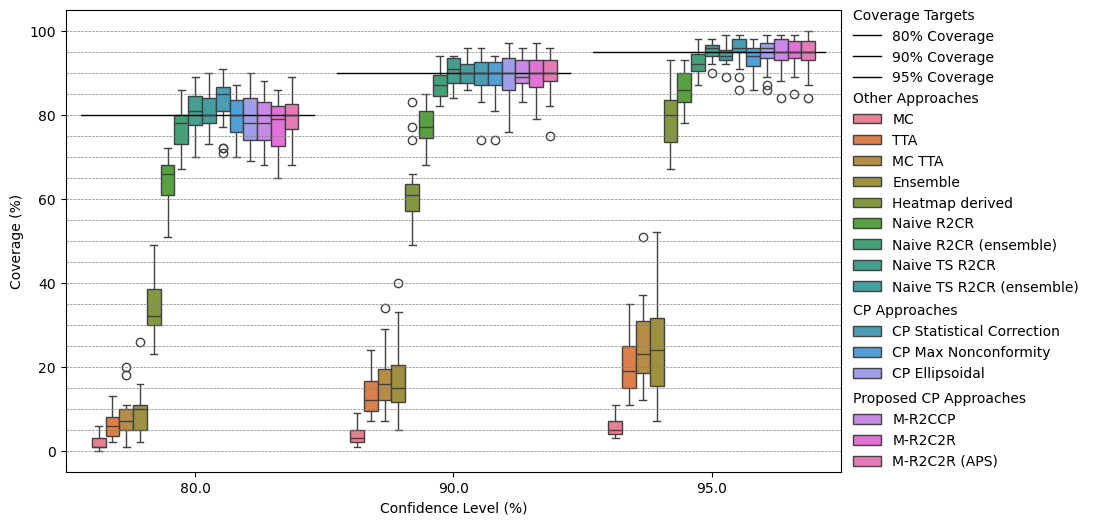

In [11]:
from matplotlib.lines import Line2D


df_isbi2015_eval_per_landmark_percantage = df_isbi2015_eval_per_landmark.copy()
df_isbi2015_eval_per_landmark_percantage["in_region"] = df_isbi2015_eval_per_landmark_percantage["in_region"] * 100
df_isbi2015_eval_per_landmark_percantage["confidence"] = df_isbi2015_eval_per_landmark_percantage["confidence"] * 100

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_isbi2015_eval_per_landmark_percantage, y=("in_region", "mean"), x="confidence", hue="Method",
            ax=ax, hue_order=hue_order)

# Captue original legend handles and labels
handles_methods, labels_methods = ax.get_legend_handles_labels()
# # Remove the original legend
ax.get_legend().remove()

# Map method names to handles
method_dict = dict(zip(labels_methods, handles_methods))

# Grouped legends
general_handles = [method_dict[m] for m in methods_general if m in method_dict]
cp_handles = [method_dict[m] for m in methods_cp if m in method_dict]
mr2c_handles = [method_dict[m] for m in methods_mr2c if m in method_dict]

# Add horizontal grid lines
for i in np.arange(0, 105, 5):
    plt.axhline(y=i, color='gray', linestyle='--', linewidth=0.5)

# Add bold coverage lines
plt.axhline(y=80, xmin=0.02, xmax=0.32, color='black', linestyle='-', linewidth=1)
plt.axhline(y=90, xmin=0.35, xmax=0.65, color='black', linestyle='-', linewidth=1)
plt.axhline(y=95, xmin=0.68, xmax=0.98, color='black', linestyle='-', linewidth=1)

# Create coverage legend elements
coverage_elements = [
    Line2D([0], [0], color='black', lw=1, label='80% Coverage'),
    Line2D([0], [0], color='black', lw=1, label='90% Coverage'),
    Line2D([0], [0], color='black', lw=1, label='95% Coverage')
]

# Create method and coverage legends next to each other
coverage_legend = ax.legend(handles=coverage_elements,
                            loc='upper left', bbox_to_anchor=(1.00, 1.03),
                            title='Coverage Targets')
cp_legend = ax.legend(cp_handles, methods_cp, loc='upper left', bbox_to_anchor=(1.00, 0.39), title='CP Approaches')
mr2c_legend = ax.legend(mr2c_handles, methods_mr2c, loc='upper left', bbox_to_anchor=(1.00, 0.20), title='Proposed CP Approaches')
general_legend = ax.legend(general_handles, methods_general, loc='upper left', bbox_to_anchor=(1.00, 0.85), title='Other Approaches')

for legend in [general_legend, cp_legend, mr2c_legend, coverage_legend]:
    legend._legend_box.align = "left"
    legend.get_frame().set_visible(False)

ax.add_artist(coverage_legend)  # Ensure both legends are displayed
ax.add_artist(cp_legend)
ax.add_artist(mr2c_legend)

# Axis labels
ax.set_ylabel("Coverage (%)")
ax.set_xlabel("Confidence Level (%)")

# Save and show
plt.savefig("../results/figures/isbi2015_coverage_box_plots.pdf", bbox_inches='tight')
plt.show()

In [12]:
df_isbi2015_eval_95 = df_isbi2015_eval[df_isbi2015_eval["confidence"] == 0.95]

# sort method by hue_order
df_isbi2015_eval_95["Method"] = pd.Categorical(df_isbi2015_eval_95["Method"], categories=hue_order, ordered=True)
df_isbi2015_eval_95 = df_isbi2015_eval_95.sort_values("Method")

# in_region_mean to percentage
df_isbi2015_eval_95["in_region"] = df_isbi2015_eval_95["in_region"] * 100

# all float columns to 5 total digits
float_cols = df_isbi2015_eval_95.select_dtypes(include=['float64']).columns
df_isbi2015_eval_95[float_cols] = df_isbi2015_eval_95[float_cols].applymap(lambda x: f"{x:.5g}")

# flatten multi index
df_isbi2015_eval_95.columns = [col[0] if col[1] == "" else col[0] + "_" + col[1]  for col in df_isbi2015_eval_95.columns]

# reoder columns
df_isbi2015_eval_95 = df_isbi2015_eval_95[["Method", "confidence", "in_region_mean", "area_mean", "area_std",
                                           "area_median", "area_q1", "area_q3",
                                           "Adaptivity"]]



df_isbi2015_eval_95.to_latex("../results/tables/isbi2015_eval_95.tex", index=False, multirow=True, multicolumn=True)
df_isbi2015_eval_95.to_csv("../results/tables/isbi2015_eval_95.csv", index=False)

df_isbi2015_eval_95

/var/folders/fb/lzd0fz_d69v05khmd495_rwr0000gn/T/ipykernel_43106/469108090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_isbi2015_eval_95["Method"] = pd.Categorical(df_isbi2015_eval_95["Method"], categories=hue_order, ordered=True)
/var/folders/fb/lzd0fz_d69v05khmd495_rwr0000gn/T/ipykernel_43106/469108090.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_isbi2015_eval_95[float_cols] = df_isbi2015_eval_95[float_cols].applymap(lambda x: f"{x:.5g}")


,Method,confidence,in_region_mean,area_mean,area_std,area_median,area_q1,area_q3,Adaptivity
41,MC,0.95,5.4737,0.30153,1.2333,0.086171,0.047153,0.18358,0.26418
38,TTA,0.95,20.684,2.7351,50.134,0.5793,0.36942,0.965,0.36987
44,MC TTA,0.95,25.474,1.4625,3.9245,0.58886,0.37783,1.0562,0.37317
35,Ensemble,0.95,25.211,5.0906,65.185,0.76865,0.47339,1.6475,0.40562
27,Heatmap derived,0.95,78.632,5.8981,5.5784,4.2713,3.2454,6.6309,0.39584
4,Naive R2CR,0.95,86.263,19.95,506.75,5.72,3.92,9.015,0.43099
31,Naive R2CR (ensemble),0.95,92.474,9.1205,6.9787,6.93,4.82,11.035,0.3867
5,Naive TS R2CR,0.95,95.316,676.41,3959.4,10.305,6.465,17.94,0.38602
32,Naive TS R2CR (ensemble),0.95,94.263,10.921,9.3519,8.09,5.63,13.263,0.37725
26,CP Statistical Correction,0.95,95.526,55.291,245.29,14.62,7.9068,32.157,0.3703


In [13]:
def get_df_adpativity_evaluation(df, confidence=0.95, decoder="local_soft_argmax"):
    area_columns = [f"area_{i}" for i in range(nb_landmarks)]
    in_region_columns = [f"in_region_{i}" for i in range(nb_landmarks)]
    error_columns = [f"error_{i}" for i in range(nb_landmarks)]
    df[in_region_columns] = df[in_region_columns].replace({"1.0": 1.0, "0.0": 0.0, "True": 1.0, "False": 0.0}).astype(bool)
    # pivot such that you have a seperate column for area, in_region and error column and a landmark_idx column
    df_long_area = pd.melt(df, id_vars=["model", "confidence", "approach", "idx",
                                                        "decoder_method", "model_filename",
                                                        "pixel_based_sampling"] + in_region_columns + error_columns,
                            value_vars=area_columns,
                            var_name="landmark_idx", value_name="area").drop(columns=in_region_columns + error_columns)
    df_long_area["landmark_idx"] = df_long_area["landmark_idx"].str.replace("area_", "").astype(int)
    df_long_in_region = pd.melt(df, id_vars=["model", "confidence", "approach", "idx",
                                                        "decoder_method", "model_filename",
                                                        "pixel_based_sampling"] + area_columns + error_columns,
                            value_vars=in_region_columns,
                            var_name="landmark_idx", value_name="in_region").drop(columns=area_columns + error_columns)
    df_long_in_region["landmark_idx"] = df_long_in_region["landmark_idx"].str.replace("in_region_", "").astype(int)
    df_long_error = pd.melt(df, id_vars=["model", "confidence", "approach", "idx",
                                                        "decoder_method", "model_filename",
                                                        "pixel_based_sampling"] + area_columns + in_region_columns,
                                value_vars=error_columns,
                                var_name="landmark_idx", value_name="error").drop(columns=area_columns + in_region_columns)
    df_long_error["landmark_idx"] = df_long_error["landmark_idx"].str.replace("error_", "").astype(int)


    df_long = pd.merge(df_long_area, df_long_in_region, on=["model", "confidence", "approach", "idx",
                                                        "decoder_method", "model_filename",
                                                        "pixel_based_sampling", "landmark_idx"], how="left")
    df_long = pd.merge(df_long, df_long_error, on=["model", "confidence", "approach", "idx",
                                                        "decoder_method", "model_filename",
                                                        "pixel_based_sampling", "landmark_idx"], how="left")
    df_long_filtered = df_long[df_long["decoder_method"]==decoder]
    df_long_filtered = df_long_filtered[df_long_filtered["confidence"] == confidence]
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_ellipsoid_heatmap_cov", "CP Ellipsoidal (heatmap cov)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_ellipsoid_sampling_cov", "CP Ellipsoidal (sampling cov)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("multi_normal_sampling_cov", "Multi Normal (sampling cov)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("multi_normal_heatmap_cov", "Multi Normal (heatmap cov)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_bonferroni_heatmap_sigma", "CP Statistical Correction (heatmap sigma)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_bonferroni_sampling_sigma", "CP Statistical Correction (sampling sigma)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_max_score_heatmap_sigma", "CP Max Nonconformity (heatmap sigma)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("cp_max_score_sampling_sigma", "CP Max Nonconformity (sampling sigma)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("mr2ccp", "M-R2CCP")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("mr2c2r_aps", "M-R2C2R (APS)")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("mr2c2r", "M-R2C2R")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("contour_hugging_ts", "Naive TS R2CR")
    df_long_filtered["approach"] = df_long_filtered["approach"].str.replace("contour_hugging", "Naive R2CR")

    df_long_filtered_ensemble = df_long_filtered[df_long_filtered["model"] == "one_hot_ensemble"]
    df_long_filtered_ls = df_long_filtered[df_long_filtered["pixel_based_sampling"] == False]
    df_long_filtered_ls = df_long_filtered_ls[df_long_filtered_ls["model"].isin(one_hot_models)]
    df_long_filtered_ls = df_long_filtered_ls[df_long_filtered_ls["approach"].isin(["Multi Normal (sampling cov)"])]
    df_long_filtered_scn_ls = df_long_filtered[df_long_filtered["pixel_based_sampling"] == False]
    df_long_filtered_scn_ls = df_long_filtered_scn_ls[df_long_filtered_scn_ls["model"].isin(["scn_mc_landmark_sampling", "scn_mc_tta_landmark_sampling"])]
    df_long_filtered_scn_ls = df_long_filtered_scn_ls[df_long_filtered_scn_ls["approach"].isin(["Multi Normal (sampling cov)"])]
    df_long_filtered_naive = df_long_filtered[df_long_filtered["approach"].isin(["Naive R2CR", "Naive TS R2CR"])]
    df_long_filtered_naive = df_long_filtered_naive[df_long_filtered_naive["model"] == "one_hot"]
    df_long_filtered_final = pd.concat([df_long_filtered_ensemble, df_long_filtered_ls,
                                                df_long_filtered_scn_ls, df_long_filtered_naive])
    df_long_filtered_final["approach"] += " " + df_long_filtered_final["model"]
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (sampling cov) one_hot_ensemble_landmark_sampling", "Ensemble")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (sampling cov) one_hot_tta_landmark_sampling", "TTA")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (sampling cov) scn_mc_landmark_sampling", "MC")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (sampling cov) scn_mc_tta_landmark_sampling", "MC TTA")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (heatmap cov) one_hot_ensemble", "Heatmap derived")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Multi Normal (sampling cov) one_hot_mc_landmark_sampling", "MC")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Naive R2CR one_hot_ensemble", "Naive R2CR (ensemble)")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace("Naive TS R2CR one_hot_ensemble", "Naive TS R2CR (ensemble)")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace(" one_hot_ensemble", "")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace(" one_hot", "")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace(" (heatmap sigma)", "")
    df_long_filtered_final["approach"] = df_long_filtered_final["approach"].str.replace(" (heatmap cov)", "")
    return df_long_filtered_final

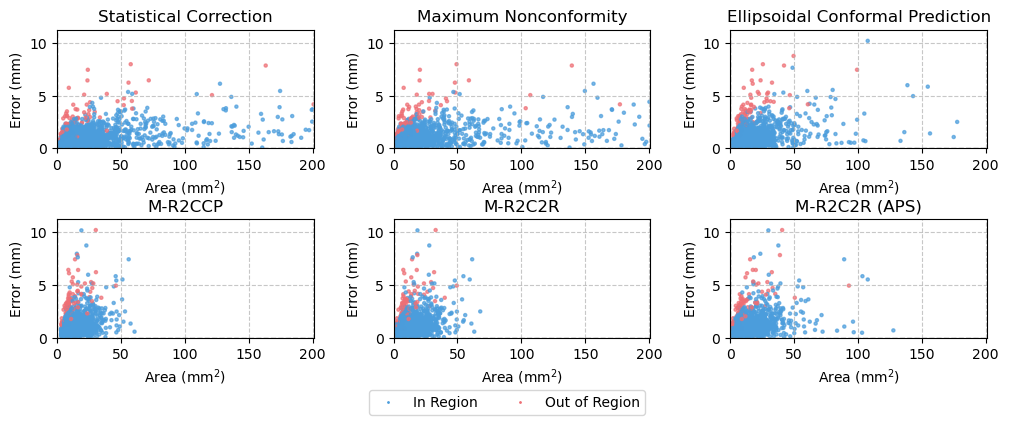

In [14]:
df_isbi2015_adaptivity_evaluation = get_df_adpativity_evaluation(df_isbi2015, confidence=0.95, decoder="local_soft_argmax")
plot_error_area_scatter(df_isbi2015_adaptivity_evaluation, save_path="../results/figures/isbi2015_adaptivity_scatter.pdf")

## MML (3D)

### Deterministic Performance

In [15]:
one_hot_models = ["one_hot", "one_hot_mc", "one_hot_mc_landmark_sampling",
                 "one_hot_ensemble", "one_hot_ensemble_landmark_sampling"]

df_mml_benchmark_one_hot_det = preprocess_performance_dict(path_results + "mml/mml_benchmark_one_hot_evaluation_det_results.pkl",
                                                      one_hot_models)

# Put sdr in percentage
df_mml_benchmark_one_hot_det[("Validation", "SDR 2mm")] = df_mml_benchmark_one_hot_det[("Validation", "SDR 2mm")] * 100
df_mml_benchmark_one_hot_det[("Validation", "SDR 2.5mm")] = df_mml_benchmark_one_hot_det[("Validation", "SDR 2.5mm")] * 100
df_mml_benchmark_one_hot_det[("Validation", "SDR 3mm")] = df_mml_benchmark_one_hot_det[("Validation", "SDR 3mm")] * 100
df_mml_benchmark_one_hot_det[("Validation", "SDR 4mm")] = df_mml_benchmark_one_hot_det[("Validation", "SDR 4mm")] * 100

df_mml_benchmark_one_hot_det[("Test", "SDR 2mm")] = df_mml_benchmark_one_hot_det[("Test", "SDR 2mm")] * 100
df_mml_benchmark_one_hot_det[("Test", "SDR 2.5mm")] = df_mml_benchmark_one_hot_det[("Test", "SDR 2.5mm")] * 100
df_mml_benchmark_one_hot_det[("Test", "SDR 3mm")] = df_mml_benchmark_one_hot_det[("Test", "SDR 3mm")] * 100
df_mml_benchmark_one_hot_det[("Test", "SDR 4mm")] = df_mml_benchmark_one_hot_det[("Test", "SDR 4mm")] * 100

df_mml_benchmark_one_hot_det.to_latex(path_results + "tables/mml_benchmark_one_hot_det.tex", index=False, escape=False)
df_mml_benchmark_one_hot_det.to_csv(path_results + "tables/mml_benchmark_one_hot_det.csv", index=False)
df_mml_benchmark_one_hot_det

Validation                    \
             Model Name                Decoder         PE SDR 2mm SDR 2.5mm   
2               ONE HOT  weighted spatial mean     1.9829   71.81     80.23   
4      ONE HOT ENSEMBLE      local soft argmax     1.6010   77.81     87.76   
7   ONE HOT ENSEMBLE LS      local soft argmax     1.6327   76.02     85.46   
9            ONE HOT MC                 argmax     1.9873   73.09     83.42   
13        ONE HOT MC LS      local soft argmax     2.0667   72.96     80.23   

                      Test                                    
   SDR 3mm SDR 4mm      PE SDR 2mm SDR 2.5mm SDR 3mm SDR 4mm  
2    84.57   90.31  1.6937   77.50     86.43   90.24   94.29  
4    89.92   93.37  1.3922   81.67     91.31   93.21   96.31  
7    89.41   93.62  1.4693   81.67     89.40   93.10   96.55  
9    86.48   90.31  1.6568   75.60     87.26   90.00   94.17  
13   86.35   90.05  1.6697   77.62     86.07   90.36   95.12

In [16]:
one_hot_models = ["one_hot", "one_hot_mc", "one_hot_mc_landmark_sampling",
                 "one_hot_ensemble", "one_hot_ensemble_landmark_sampling"]

df_mml_benchmark_adj_one_hot_det = preprocess_performance_dict(path_results + "mml/mml_benchmark_adj_one_hot_evaluation_det_results.pkl",
                                                      one_hot_models)

# Put sdr in percentage
df_mml_benchmark_adj_one_hot_det[("Validation", "SDR 2mm")] = df_mml_benchmark_adj_one_hot_det[("Validation", "SDR 2mm")] * 100
df_mml_benchmark_adj_one_hot_det[("Validation", "SDR 2.5mm")] = df_mml_benchmark_adj_one_hot_det[("Validation", "SDR 2.5mm")] * 100
df_mml_benchmark_adj_one_hot_det[("Validation", "SDR 3mm")] = df_mml_benchmark_adj_one_hot_det[("Validation", "SDR 3mm")] * 100
df_mml_benchmark_adj_one_hot_det[("Validation", "SDR 4mm")] = df_mml_benchmark_adj_one_hot_det[("Validation", "SDR 4mm")] * 100

df_mml_benchmark_adj_one_hot_det[("Test", "SDR 2mm")] = df_mml_benchmark_adj_one_hot_det[("Test", "SDR 2mm")] * 100
df_mml_benchmark_adj_one_hot_det[("Test", "SDR 2.5mm")] = df_mml_benchmark_adj_one_hot_det[("Test", "SDR 2.5mm")] * 100
df_mml_benchmark_adj_one_hot_det[("Test", "SDR 3mm")] = df_mml_benchmark_adj_one_hot_det[("Test", "SDR 3mm")] * 100
df_mml_benchmark_adj_one_hot_det[("Test", "SDR 4mm")] = df_mml_benchmark_adj_one_hot_det[("Test", "SDR 4mm")] * 100

df_mml_benchmark_adj_one_hot_det.to_latex(path_results + "tables/mml_benchmark_adj_one_hot_det.tex", index=False, escape=False)
df_mml_benchmark_adj_one_hot_det.to_csv(path_results + "tables/mml_benchmark_adj_one_hot_det.csv", index=False)
df_mml_benchmark_adj_one_hot_det

Validation                    \
             Model Name                Decoder         PE SDR 2mm SDR 2.5mm   
2               ONE HOT  weighted spatial mean     2.1221   69.90     78.32   
4      ONE HOT ENSEMBLE      local soft argmax     1.6947   75.64     86.61   
7   ONE HOT ENSEMBLE LS      local soft argmax     1.7366   74.11     83.42   
10           ONE HOT MC      local soft argmax     2.0540   70.54     82.02   
13        ONE HOT MC LS      local soft argmax     2.2088   69.39     77.68   

                      Test                                    
   SDR 3mm SDR 4mm      PE SDR 2mm SDR 2.5mm SDR 3mm SDR 4mm  
2    83.93   89.41  1.6937   77.50     86.43   90.24   94.29  
4    89.29   92.86  1.3922   81.67     91.31   93.21   96.31  
7    88.14   92.86  1.4693   81.67     89.40   93.10   96.55  
10   85.59   90.18  1.6740   76.31     88.21   90.71   93.57  
13   83.42   89.16  1.6648   78.69     86.19   90.24   95.48

### UQ Performance

In [17]:
paths_mml_csv = glob(path_results + "mml/*.csv")
df_mml = pd.concat([pd.read_csv(path) for path in paths_mml_csv], ignore_index=True).drop(columns=["Unnamed: 0"])
nb_landmarks = 14

In [18]:
df_mml["model"].unique()

array(['one_hot_mc', 'one_hot_mc_landmark_sampling', 'one_hot',
       'one_hot_ensemble_landmark_sampling', 'one_hot_ensemble'],
      dtype=object)

In [19]:
df_mml_eval, df_mml_eval_per_landmark = preprocess_uncertainty_evaluation(df_mml, nb_landmarks)

df_mml_eval = df_mml_eval.rename(columns={
    "area_mean": "Area Mean",
    "area_median": "Area Median",
    "area_q1": "Area Q1",
    "area_q3": "Area Q3",
    "area_std": "Area Std",
    "in_region_mean": "Coverage Mean",
    "error_mean": "Error Mean",
    "adaptivity": "Adaptivity",
    "approach": "Method"
})

df_mml_eval_per_landmark = df_mml_eval_per_landmark.rename(columns={
    "area_mean": "Area Mean",
    "area_median": "Area Median",
    "area_q1": "Area Q1",
    "area_q3": "Area Q3",
    "area_std": "Area Std",
    "in_region_mean": "Coverage Mean",
    "error_mean": "Error Mean",
    "adaptivity": "Adaptivity",
    "approach": "Method"
})

/var/folders/fb/lzd0fz_d69v05khmd495_rwr0000gn/T/ipykernel_43106/1626142400.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[in_region_columns] = df[in_region_columns].replace({"1.0": 1.0, "0.0": 0.0, "True": 1.0, "False": 0.0}).astype(bool)
/var/folders/fb/lzd0fz_d69v05khmd495_rwr0000gn/T/ipykernel_43106/1626142400.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda group: calculate_correlation(group[["area", "error"]])).values
/var/folders/fb/

In [20]:
hue_order = ["MC", "Ensemble", "Heatmap derived", "Naive R2CR", "Naive R2CR (ensemble)",
                "Naive TS R2CR", "Naive TS R2CR (ensemble)", "CP Statistical Correction", "CP Max Nonconformity", "CP Ellipsoidal",
                "M-R2CCP", "M-R2C2R", "M-R2C2R (APS)"]

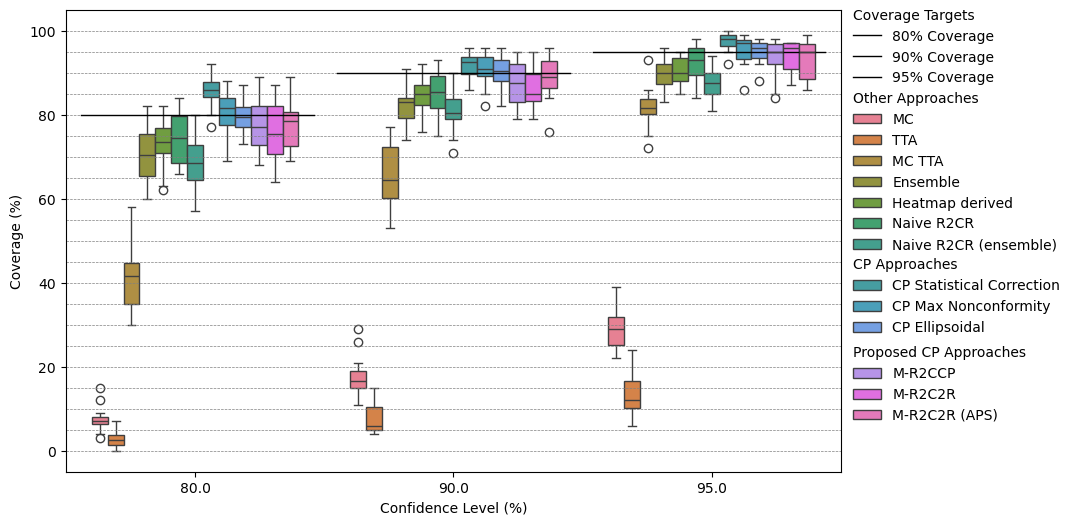

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_mml_eval_per_landmark_percantage = df_mml_eval_per_landmark.copy()
df_mml_eval_per_landmark_percantage["in_region"] = df_mml_eval_per_landmark_percantage["in_region"] * 100
df_mml_eval_per_landmark_percantage["confidence"] = df_mml_eval_per_landmark_percantage["confidence"] * 100

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_mml_eval_per_landmark_percantage, y=("in_region", "mean"), x="confidence", hue="Method",
            ax=ax, hue_order=hue_order)
# Captue original legend handles and labels
handles_methods, labels_methods = ax.get_legend_handles_labels()
# # Remove the original legend
ax.get_legend().remove()

# Map method names to handles
method_dict = dict(zip(labels_methods, handles_methods))

# Grouped legends
general_handles = [method_dict[m] for m in methods_general if m in method_dict]
cp_handles = [method_dict[m] for m in methods_cp if m in method_dict]
mr2c_handles = [method_dict[m] for m in methods_mr2c if m in method_dict]

# Add horizontal grid lines
for i in np.arange(0, 105, 5):
    plt.axhline(y=i, color='gray', linestyle='--', linewidth=0.5)

# Add bold coverage lines
plt.axhline(y=80, xmin=0.02, xmax=0.32, color='black', linestyle='-', linewidth=1)
plt.axhline(y=90, xmin=0.35, xmax=0.65, color='black', linestyle='-', linewidth=1)
plt.axhline(y=95, xmin=0.68, xmax=0.98, color='black', linestyle='-', linewidth=1)

# Create coverage legend elements
coverage_elements = [
    Line2D([0], [0], color='black', lw=1, label='80% Coverage'),
    Line2D([0], [0], color='black', lw=1, label='90% Coverage'),
    Line2D([0], [0], color='black', lw=1, label='95% Coverage')
]

# Create method and coverage legends next to each other
coverage_legend = ax.legend(handles=coverage_elements,
                            loc='upper left', bbox_to_anchor=(1.00, 1.03),
                            title='Coverage Targets')
cp_legend = ax.legend(cp_handles, methods_cp, loc='upper left', bbox_to_anchor=(1.00, 0.49), title='CP Approaches')
mr2c_legend = ax.legend(mr2c_handles, methods_mr2c, loc='upper left', bbox_to_anchor=(1.00, 0.30), title='Proposed CP Approaches')
general_legend = ax.legend(general_handles, methods_general, loc='upper left', bbox_to_anchor=(1.00, 0.85), title='Other Approaches')

for legend in [general_legend, cp_legend, mr2c_legend, coverage_legend]:
    legend._legend_box.align = "left"
    legend.get_frame().set_visible(False)

ax.add_artist(coverage_legend)  # Ensure both legends are displayed
ax.add_artist(cp_legend)
ax.add_artist(mr2c_legend)

# Axis labels
ax.set_ylabel("Coverage (%)")
ax.set_xlabel("Confidence Level (%)")

plt.savefig("../results/figures/mml_coverage_box_plots.pdf", bbox_inches='tight')

plt.show()

In [22]:
df_mml_eval_95 = df_mml_eval[df_mml_eval["confidence"] == 0.95]

# sort method by hue_order
df_mml_eval_95["Method"] = pd.Categorical(df_mml_eval_95["Method"], categories=hue_order, ordered=True)
df_mml_eval_95 = df_mml_eval_95.sort_values("Method")


# in_region_mean to percentage
df_mml_eval_95["in_region"] = df_mml_eval_95["in_region"] * 100


# all float columns to 5 total digits
float_cols = df_mml_eval_95.select_dtypes(include=['float64']).columns
df_mml_eval_95[float_cols] = df_mml_eval_95[float_cols].applymap(lambda x: f"{x:.5g}")

# flatten multi index
df_mml_eval_95.columns = [col[0] if col[1] == "" else col[0] + "_" + col[1]  for col in df_mml_eval_95.columns]

# reoder columns
df_mml_eval_95 = df_mml_eval_95[["Method", "confidence", "in_region_mean", "area_mean", "area_std",
                                           "area_median", "area_q1", "area_q3",
                                           "Adaptivity"]]


df_mml_eval_95.to_latex("../results/tables/mml_eval_95.tex", index=False, multirow=True, multicolumn=True)
df_mml_eval_95.to_csv("../results/tables/mml_eval_95.csv", index=False)

df_mml_eval_95

/var/folders/fb/lzd0fz_d69v05khmd495_rwr0000gn/T/ipykernel_43106/2358747800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mml_eval_95["Method"] = pd.Categorical(df_mml_eval_95["Method"], categories=hue_order, ordered=True)
/var/folders/fb/lzd0fz_d69v05khmd495_rwr0000gn/T/ipykernel_43106/2358747800.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_mml_eval_95[float_cols] = df_mml_eval_95[float_cols].applymap(lambda x: f"{x:.5g}")


,Method,confidence,in_region_mean,area_mean,area_std,area_median,area_q1,area_q3,Adaptivity
38,MC,0.95,29.5,232.5,1776.9,2.1958,0.8617,8.9424,0.57939
35,Ensemble,0.95,13.357,63.108,574.84,0.23228,0.07322,1.3626,0.44367
27,Heatmap derived,0.95,81.857,626.91,3453.1,21.555,9.2268,69.694,0.30145
4,Naive R2CR,0.95,89.857,1739.4,9990.2,39.653,22.812,75.474,0.35467
31,Naive R2CR (ensemble),0.95,90.286,1661.5,10607,29.803,20.506,53.173,0.33953
5,Naive TS R2CR,0.95,92.571,3133.1,13212,52.697,28.582,116.43,0.34988
32,Naive TS R2CR (ensemble),0.95,87.5,572.89,4783.6,23.842,16.767,41.376,0.34154
26,CP Statistical Correction,0.95,97.429,3.63e+07,5.6295e+08,542.33,109.93,7733.2,0.26521
25,CP Max Nonconformity,0.95,95.357,2.7845e+07,4.0643e+08,483.26,101.36,6759.5,0.25196
24,CP Ellipsoidal,0.95,95,2971.7,19684,73.406,33.235,251,0.28694


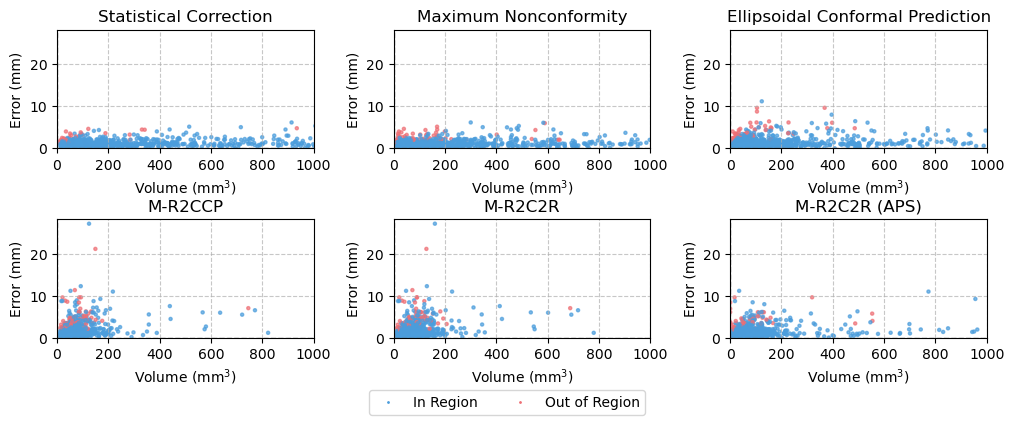

In [23]:
df_mml_adaptivity_evaluation = get_df_adpativity_evaluation(df_mml, confidence=0.95, decoder="local_soft_argmax")
plot_error_area_scatter(df_mml_adaptivity_evaluation, save_path="../results/figures/mml_adaptivity_scatter.pdf", dim=3, lim_axis=1000)